<a href="https://colab.research.google.com/github/Drahtesel/Credit_Scoring_Prototypes/blob/main/Modellvergleich.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lime
import lime
import lime.lime_tabular

In [8]:
# ============================================================
# Finales Training und Vergleich der Vorhersagequalität
# ============================================================
# Dieses Notebook:
# Lädt die vorbereiteten Daten (X, y)
# (Die Daten wurde im Rahmen des Notebook "Datenvorbereitung" vorbereitet)
#
# Initialisiert die folgenden Modelle unter Nutzung der optimalen Hyperparameter:
#       - Logistische Regression
#       - Random Forest
#       - XGBoost
#       - Neuronales Netz (MLP)
# (Die Hyperparameter wurden innerhalb des Notebooks "Optimierung" identifiziert)
#
## Trainiert die Prototypen
# Führt Cross-Validation durch (10-Fold)
#
# Wendet die folgenden Methoden an, die die Erklärbarkeit erhöhen:
#       - SHAP
#       - LIME
# ============================================================


import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TunedThresholdClassifierCV, StratifiedKFold, train_test_split, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    make_scorer, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, precision_recall_curve, roc_curve,
    average_precision_score, log_loss
)

import shap
from sklearn.inspection import permutation_importance, PartialDependenceDisplay



In [ ]:
# --- Datenverzeichnis ----------------------------------------
data_dir = "/content/drive/MyDrive/Thesis/Daten/DataPreprocess/german_credit_prepared"

# Speichern von Grafiken
output_dir = '/content/drive/MyDrive/Thesis/Grafiken'

# --- Daten laden ---------------------------------------------
X = pd.read_csv(f"{data_dir}/X_prepared_FS_15.csv")
y = pd.read_csv(f"{data_dir}/y_labels_FS_15.csv")

if isinstance(y, pd.DataFrame):
   y = y.iloc[:, 0]

models = ["LR", "RF", "XGB", "NN"]

# --- Färbung für Diagramme --- #
colors = {
    "LR": "tab:blue",
    "RF": "tab:green",
    "XGB": "tab:red",
    "NN": "tab:purple"
}

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.34, random_state=42, stratify=y
)

# --- Define class_weight_map ---
class_weight_map = {0: 1, 1: 5}

print("Daten geladen:")
print(f"X-Shape: {X.shape}, y-Shape: {y.shape}")

Daten geladen:
X-Shape: (1000, 42), y-Shape: (1000,)


In [ ]:
# ============================================================
# --- Hilfsfunktionen ---
# ============================================================

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def mean_ci_curve(list_of_curves):
    x_new = np.linspace(0, 1, 200)

    y_interp = []
    for x, y in list_of_curves:
        y_new = np.interp(x_new, x, y)
        y_interp.append(y_new)

    y_interp = np.array(y_interp)

    mean = y_interp.mean(axis=0)
    std  = y_interp.std(axis=0)

    ci_low  = mean - 1.96 * std / np.sqrt(len(list_of_curves))
    ci_high = mean + 1.96 * std / np.sqrt(len(list_of_curves))

    return x_new, mean, ci_low, ci_high


#Kostenmatrix: FN = 5, FP = 1
def cost_based_score(y_true, y_pred):
    fn = np.sum((y_true == 1) & (y_pred == 0))  # False Negatives
    fp = np.sum((y_true == 0) & (y_pred == 1))  # False Positives
    cost = 5 * fn + 1 * fp
    return -cost

cost_scorer = make_scorer(cost_based_score)

In [13]:
# Modelle werden initialisiert, dabei wird für jedes Modell die besten Hyperparameter
# mitgegeben, welche innerhalb der Bayesian Optimization gefunden wurden.

models = {}

# ============================================================
# Logistic Regression  (Best)
# penalty_num = 1.931899373004111 -> l2
# C = 0.1546198805628967 ~ 0.1546
# max_iter = 808.8759013578529 ~ 809
# ============================================================

models["LR"] = LogisticRegression(
    penalty="l2",
    C=0.1546,
    solver="liblinear",
    max_iter=809,
    random_state=42
)


# ============================================================
# Random Forest  (Best)
# n_estimators = 157.55183698544803 ~ 158
# max_depth = 16.902047828739427 ~ 17
# min_samples_split = 4.006214142616203 ~ 4
# min_samples_leaf = 4.195301787774554 ~ 4
# max_features = 12.685751882611433 ~ 13
# criterion_num = 2.0 -> entropy
# ============================================================

models["RF"] = RandomForestClassifier(
    n_estimators=158,
    max_depth=17,
    min_samples_split=4,
    min_samples_leaf=4,
    max_features=13,
    criterion="entropy",
    random_state=42,
    n_jobs=-1
)


# ============================================================
# XGBoost  (Best)
# n_estimators = 84.39892848538969 ~ 84
# max_depth = 3.735142261085808 ~ 4
# learning_rate = 0.1408404244699492 ~ 0.1408
# subsample = 0.8335741651642962 ~ 0.8336
# colsample_bytree = 0.609140992220957 ~ 0.6091
# gamma = 0.7162505127777915 ~ 0.7163
# min_child_weight = 1.9004156542307995 ~ 1.9
# reg_alpha = 2.830371351065982 ~ 2.8304
# reg_lambda = 3.2940020164375814 ~ 3.2940
# ============================================================

models["XGB"] = XGBClassifier(
    n_estimators=84,
    max_depth=4,
    learning_rate=0.1408,
    subsample=0.8336,
    colsample_bytree=0.6091,
    gamma=0.7163,
    min_child_weight=1.9,
    reg_alpha=2.8304,
    reg_lambda=3.2940,
    eval_metric="logloss",
    objective="binary:logistic",
    random_state=42,
    verbosity=0
)


# ============================================================
# Neural Network  (Best)
# n_layers = 2.169357893245109  ~ 2
# n_neurons = 26.057360338427756 ~ 26
# alpha = 0.01
# learning_rate_init = 0.0060571179633747 ~ 0.006057
# learning_rate_idx = 2.0 -> adaptive
# batch_size = 46.16082092287091 ~ 46
# max_iter = 699.8370647892802 ~ 700
# activation_num = 2.0 -> relu
# ============================================================

hidden_layers = tuple([26] * 2)

models["NN"] = Pipeline([
    ("scaler", StandardScaler()),
    ("nn", MLPClassifier(
        hidden_layer_sizes=hidden_layers,
        alpha=0.01,
        learning_rate_init=0.006057,
        batch_size=46,
        max_iter=700,
        early_stopping=True,
        activation="relu",
        solver="adam",
        learning_rate="adaptive",
        random_state=42
    ))
])

Starting 1x 10-Fold Cross-Validation...
--- Run 1/1 ---

Cross-Validation complete. Generating plots and summary.


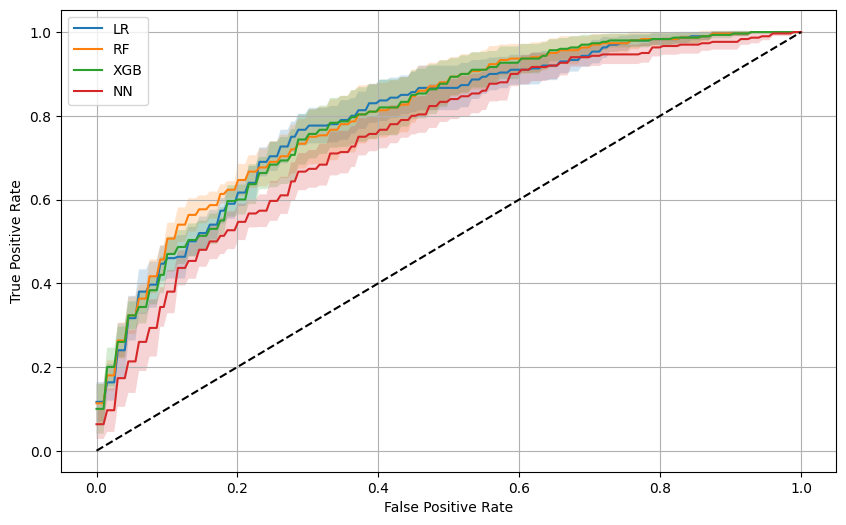

,AUC,Accuracy,LogLoss,Expected Cost
Model,,,,
RF,0.8019 ± 0.0461,0.769 ± 0.0166,0.4856 ± 0.034,93.9 ± 11.4
XGB,0.7949 ± 0.0354,0.754 ± 0.0126,0.4869 ± 0.028,93.4 ± 10.1
LR,0.794 ± 0.0419,0.768 ± 0.029,0.4881 ± 0.034,90.4 ± 14.6
NN,0.7492 ± 0.0369,0.732 ± 0.0308,0.6792 ± 0.2397,92.0 ± 17.3


In [14]:
# Konfiguration der Kreuzvalidierung
N_RUNS = 1  # mehrere Durchgänge für höhere Ergebnisstabilität
N_SPLITS = 10 # Folds je Kreuzvalidierung

# Berücksichtigung der asymmetrischen Kosten
# for name, model in models.items():
#     if not isinstance(model, TunedThresholdClassifierCV):
#         models[name] = TunedThresholdClassifierCV(
#             estimator=model,
#             scoring=cost_scorer,
#             cv=N_SPLITS
#         )

results_all_folds = []
roc_data = {m: [] for m in models.keys()}

print(f"Starting {N_RUNS}x {N_SPLITS}-Fold Cross-Validation...")

for run_idx in range(N_RUNS):
    print(f"--- Run {run_idx+1}/{N_RUNS} ---")

    # Stratifizierte Kreuzvalidierung für robustere Ergebnisse
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=run_idx)

    for name, model in models.items():
        # Random State um Zufälligkeiten zwischen den Runs zuzulassen
        if hasattr(model, "random_state"):
            model.random_state = None

        if hasattr(model, "steps") and hasattr(model.steps[-1][1], "random_state"):
            model.steps[-1][1].random_state = None

        for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
            X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
            y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

            # Training der Modelle
            model.fit(X_train_fold, y_train_fold)

            # Get predicted probabilities and classes for the test data of the current fold
            y_probs_fold = model.predict_proba(X_test_fold)[:, 1]
            y_preds_fold = model.predict(X_test_fold)

            # Metriken berechnen
            auc_fold = roc_auc_score(y_test_fold, y_probs_fold)
            logl_fold = log_loss(y_test_fold, y_probs_fold)
            acc_fold = accuracy_score(y_test_fold, y_preds_fold)
            f1_fold = f1_score(y_test_fold, y_preds_fold)
            fn = np.sum((y_test_fold == 1) & (y_preds_fold == 0))
            fp = np.sum((y_test_fold == 0) & (y_preds_fold == 1))
            expected_cost_fold = 5 * fn + 1 * fp

            results_all_folds.append({
                "Run": run_idx,
                "Fold": fold_idx,
                "Model": name,
                "AUC": auc_fold,
                "LogLoss": logl_fold,
                "Accuracy": acc_fold,
                "ExpectedCost": expected_cost_fold
            })

            fpr, tpr, _ = roc_curve(y_test_fold, y_probs_fold)
            roc_data[name].append((fpr, tpr))

print("\nCross-Validation complete. Generating plots and summary.")

# --- Visualisierung der ROC Kurve mit 95% Konfidenzintervallen ---
plt.figure(figsize=(10,6))
for name in models.keys():
    x, mean, lo, hi = mean_ci_curve(roc_data[name])
    plt.plot(x, mean, label=name)
    plt.fill_between(x, lo, hi, alpha=0.2)
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.savefig(f"{output_dir}/ROC_Curves.png")
plt.show()


# --- Zusammenfassung der Metriken über alle Folds und Runs ---
df_results_all_folds = pd.DataFrame(results_all_folds)

summary_metrics = df_results_all_folds.groupby("Model").agg(
    AUC_mean = ("AUC", "mean"),
    AUC_std   = ("AUC", "std"),
    LogLoss_mean = ("LogLoss", "mean"),
    LogLoss_std   = ("LogLoss", "std"),
    Acc_mean = ("Accuracy", "mean"),
    Acc_std  = ("Accuracy", "std"),
    ExpCost_mean = ("ExpectedCost", "mean"),
    ExpCost_std  = ("ExpectedCost", "std")
)

# Formatierung der Ergebnisse
summary_formatted = pd.DataFrame({
    "AUC":      summary_metrics["AUC_mean"].round(4).astype(str) + " ± " + summary_metrics["AUC_std"].round(4).astype(str),
    "Accuracy": summary_metrics["Acc_mean"].round(4).astype(str) + " ± " + summary_metrics["Acc_std"].round(4).astype(str),
    "LogLoss":  summary_metrics["LogLoss_mean"].round(4).astype(str) + " ± " + summary_metrics["LogLoss_std"].round(4).astype(str),
    "Expected Cost": summary_metrics["ExpCost_mean"].round(1).astype(str) + " ± " + summary_metrics["ExpCost_std"].round(1).astype(str)
})

summary_formatted['AUC_numeric'] = summary_metrics['AUC_mean'].round(4)
summary_formatted = summary_formatted.sort_values(by='AUC_numeric', ascending=False).drop(columns='AUC_numeric')

display(summary_formatted)


SHAP


=== SHAP Analysis (Original Models) ===

--- SHAP for LR (Original Models) ---


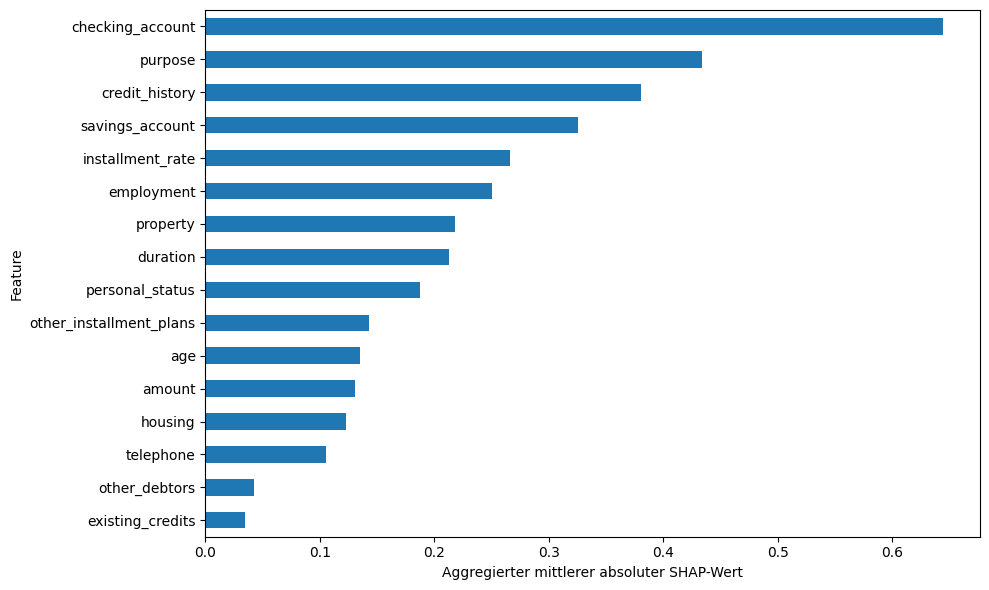


--- SHAP for RF (Original Models) ---


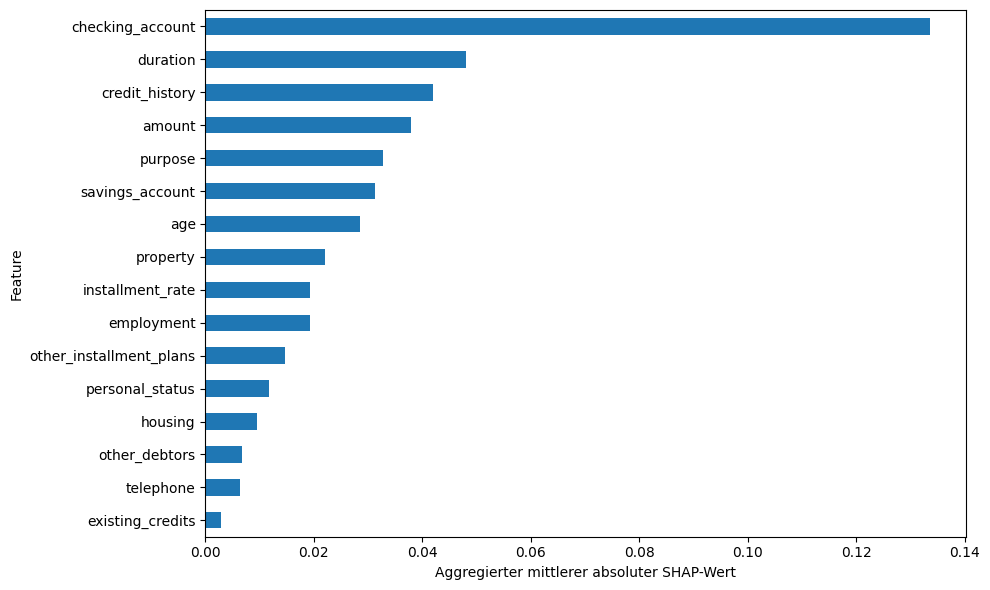


--- SHAP for XGB (Original Models) ---


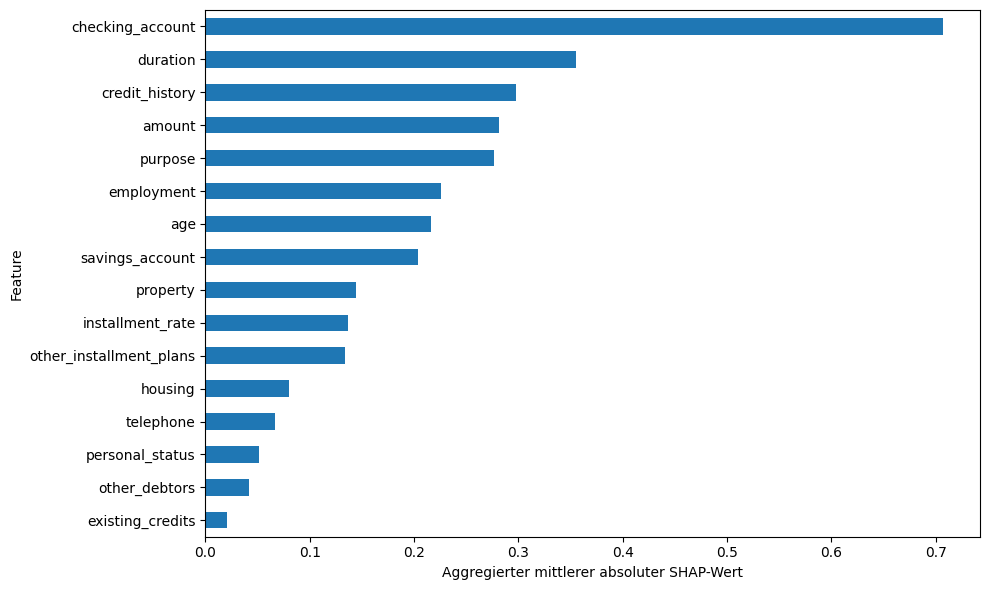


--- SHAP for NN (Original Models) ---


  0%|          | 0/100 [00:00<?, ?it/s]

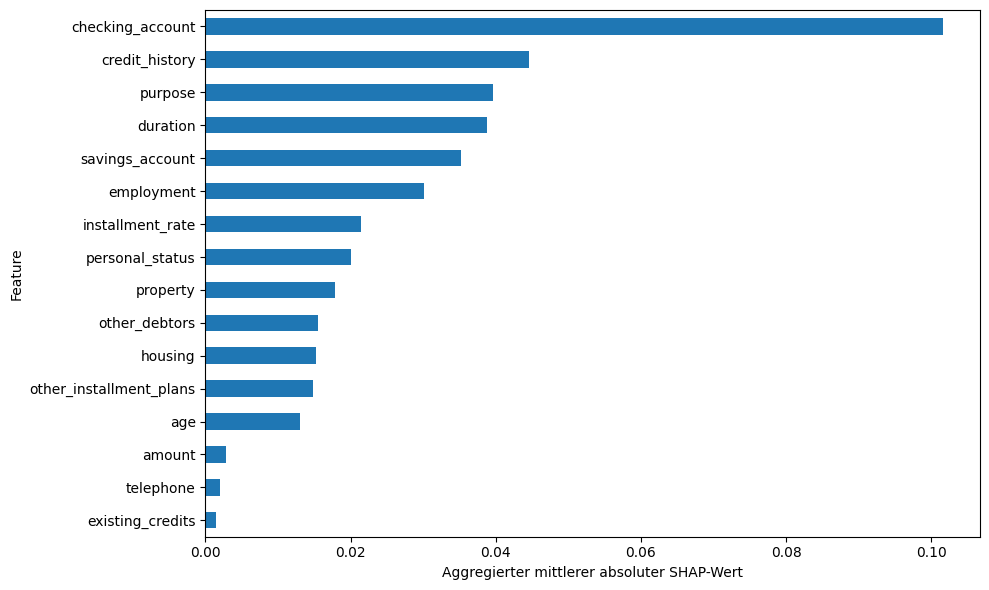

In [16]:
# @title SHAP

warnings.filterwarnings('ignore')

def run_shap_analysis_and_plot(models_dict, X_train_data, X_test_data, title_suffix, include_checking_account_prefix=True, top_n_features=15):

    prefixes = [
        'credit_history',
        'checking_account',
        'purpose',
        'savings_account',
        'employment',
        'personal_status',
        'other_debtors',
        'property',
        'housing',
        'job',
        'telephone',
        'foreign_worker',
        'other_installment_plans'
    ]

    # Merkmale aggregieren, welche durch OHE getrennt wurden
    def get_original_feature_name(col_name):
        for prefix in prefixes:
            if col_name.startswith(f'{prefix}_'):
                return prefix
        return col_name

    print(f"\n=== SHAP Analysis{title_suffix} ===")

    for name, model in models_dict.items():
        print(f"\n--- SHAP for {name}{title_suffix} ---")

        if isinstance(X_train_data, np.ndarray):
            X_train_data_processed = pd.DataFrame(X_train_data, columns=X_train.columns)
        else:
            X_train_data_processed = X_train_data

        if isinstance(X_test_data, np.ndarray):
            X_test_data_processed = pd.DataFrame(X_test_data, columns=X_test.columns if name not in ["LR", "NN"] else X_train_data_processed.columns)
        else:
            X_test_data_processed = X_test_data

        if name == "LR":
            explainer_X_train_float = X_train_data_processed.astype(float)
            explainer_X_test_float = X_test_data_processed.astype(float)
            explainer = shap.LinearExplainer(model, explainer_X_train_float)
            shap_values = explainer.shap_values(explainer_X_test_float)
            X_plot_data = X_test_data_processed

        elif name == "RF" or name == "XGB":
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test_data_processed)
            X_plot_data = X_test_data_processed

        else:
            def nn_predict_proba(X):
                return model.predict_proba(X.astype(float))

            background_data_for_explainer = shap.sample(X_train_data_processed, 100).astype(float)
            explainer = shap.KernelExplainer(
                nn_predict_proba,
                background_data_for_explainer,
            )
            X_test_for_explanation = X_test_data_processed.iloc[:100].astype(float)
            shap_values = explainer.shap_values(X_test_for_explanation)
            X_plot_data = X_test_data_processed.iloc[:100]

        # Extract SHAP values for the positive class
        if isinstance(shap_values, list):
            shap_values_for_plotting = shap_values[1]
        elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
            shap_values_for_plotting = shap_values[:, :, 1]
        else:
            shap_values_for_plotting = shap_values

        # Calculate mean absolute SHAP values for individual features
        mean_abs_shap_values = np.abs(shap_values_for_plotting).mean(0)

        feature_names_plot = X_plot_data.columns.tolist() if hasattr(X_plot_data, 'columns') else [f'Feature {i}' for i in range(X_plot_data.shape[1])]

        # Aggregate SHAP values by original conceptual feature name
        aggregated_shap_values = {}
        for i, feature_name_ind in enumerate(feature_names_plot):
            original_feature = get_original_feature_name(feature_name_ind)
            if original_feature not in aggregated_shap_values:
                aggregated_shap_values[original_feature] = 0
            aggregated_shap_values[original_feature] += mean_abs_shap_values[i]

        # Create a Series from aggregated values
        shap_importance_aggregated = pd.Series(aggregated_shap_values)

        # Sort and select top N features for plotting
        shap_importance_aggregated = shap_importance_aggregated.sort_values(ascending=False).head(top_n_features)

        plt.figure(figsize=(10, 6))
        shap_importance_aggregated.plot(kind='barh')
        plt.xlabel('Aggregierter mittlerer absoluter SHAP-Wert')
        plt.ylabel('Feature')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig(f"{output_dir}/SHAP_{name}{title_suffix}.png")
        plt.show()

# --- Call the consolidated function for original models ---
run_shap_analysis_and_plot(models, X_train, X_test, title_suffix=' (Original Models)', include_checking_account_prefix=True, top_n_features=20)


LIME

In [19]:
# @title
# Liste an Merkmalen für LIME
feature_names = X_train.columns.tolist()

# Konvertieren von DataFrames in NumPy Arrays für den LIME explainer
X_train_np = X_train.values
X_test_np = X_test.values

# Anzahl an Erklärungen
num_explanations = 3
example_indices = [0, 1, 2]



=== LIME Explanations ===

--- Model: LR ---

Instance 0 (True Label: 0, Predicted Label: 0)


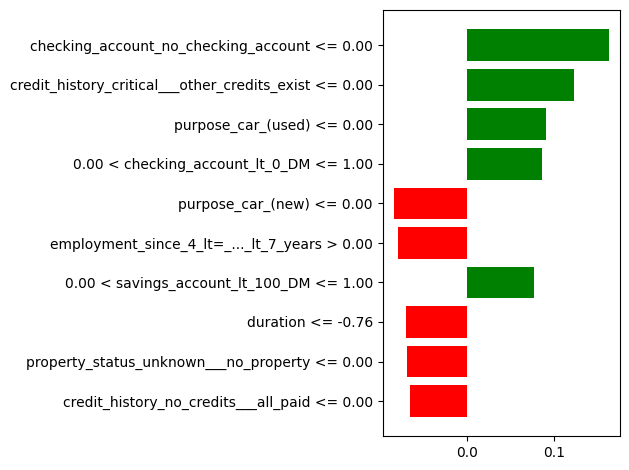


Instance 1 (True Label: 1, Predicted Label: 1)


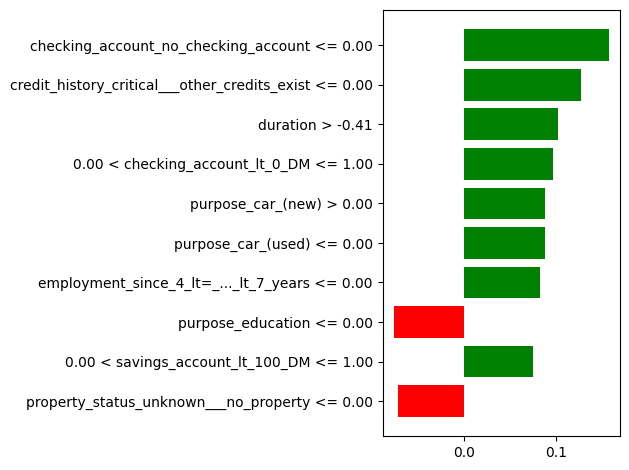


Instance 2 (True Label: 0, Predicted Label: 0)


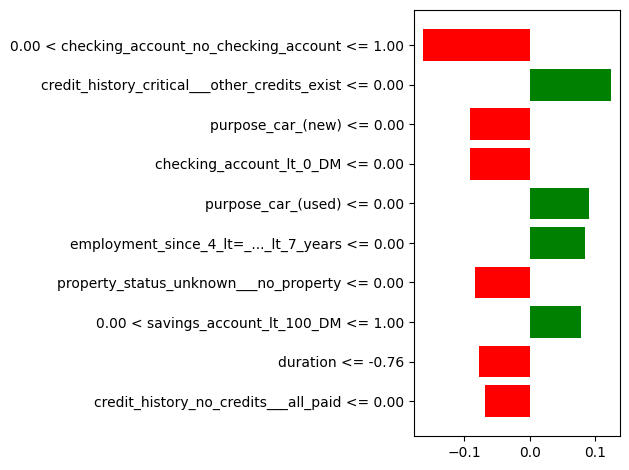


--- Model: RF ---

Instance 0 (True Label: 0, Predicted Label: 0)


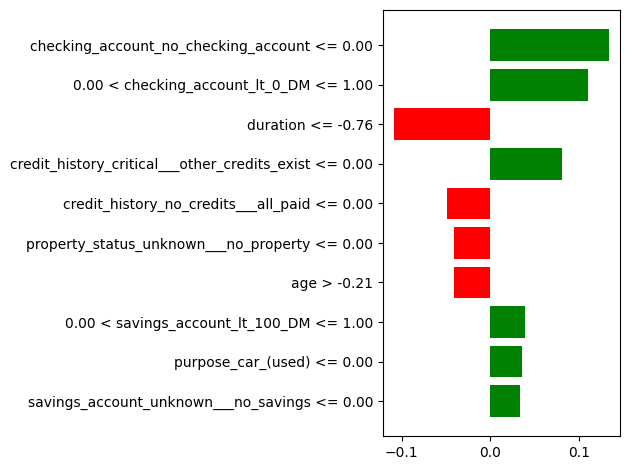


Instance 1 (True Label: 1, Predicted Label: 1)


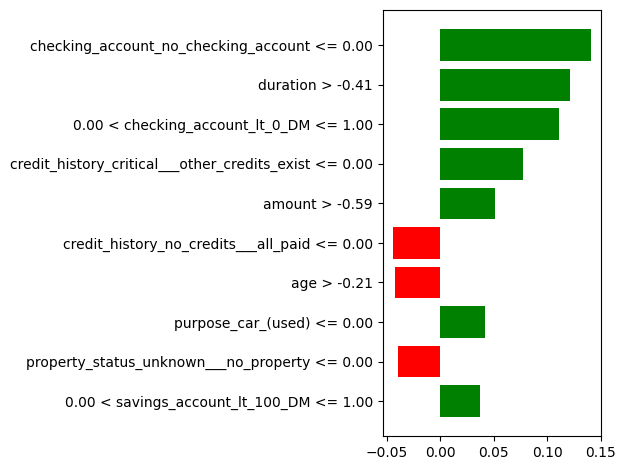


Instance 2 (True Label: 0, Predicted Label: 0)


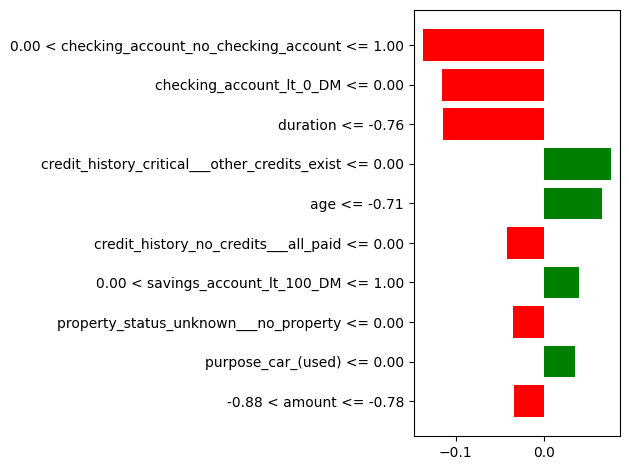


--- Model: XGB ---

Instance 0 (True Label: 0, Predicted Label: 0)


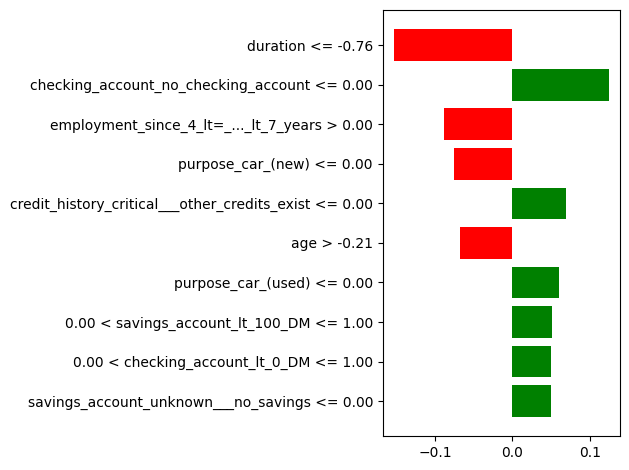


Instance 1 (True Label: 1, Predicted Label: 1)


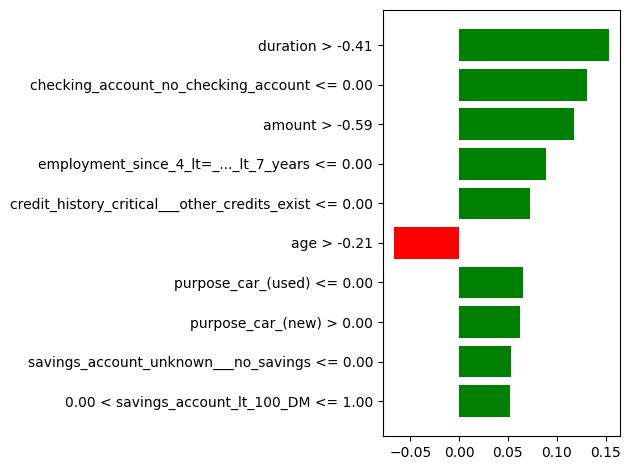


Instance 2 (True Label: 0, Predicted Label: 0)


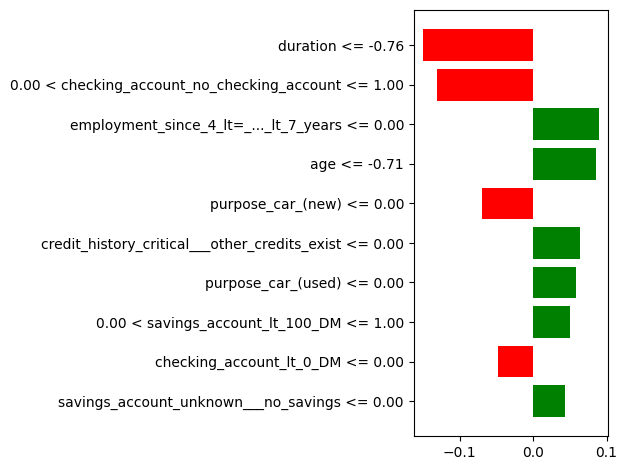


--- Model: NN ---

Instance 0 (True Label: 0, Predicted Label: 0)


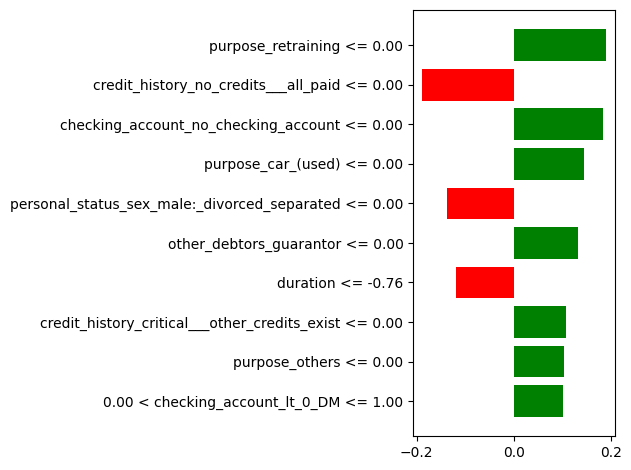


Instance 1 (True Label: 1, Predicted Label: 1)


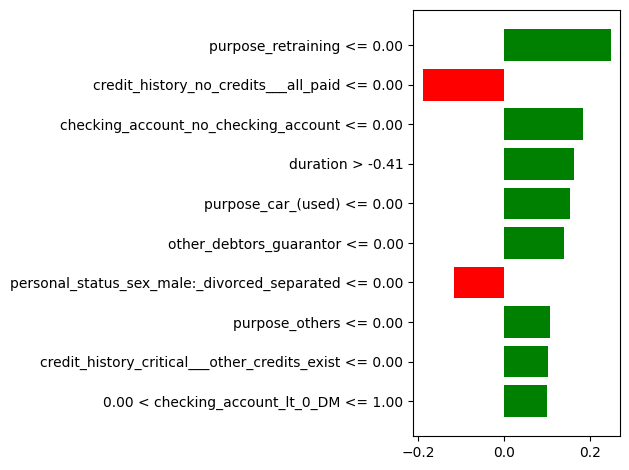


Instance 2 (True Label: 0, Predicted Label: 0)


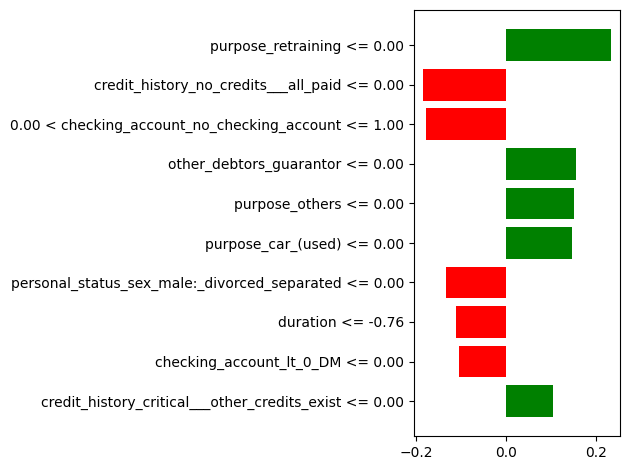

In [20]:
# @title LIME

print("\n=== LIME Explanations ===")

for name, model in models.items():
    print(f"\n--- Model: {name} ---")

    if name == "NN":
        def predict_proba_nn_pipeline(X_raw):
            return model.predict_proba(X_raw)

        explainer = lime.lime_tabular.LimeTabularExplainer(
            training_data=X_train_np,
            feature_names=feature_names,
            class_names=["Good Credit", "Bad Credit"],
            mode='classification'
        )
        predict_fn = predict_proba_nn_pipeline

    else:
        explainer = lime.lime_tabular.LimeTabularExplainer(
            training_data=X_train_np,
            feature_names=feature_names,
            class_names=["Good Credit", "Bad Credit"],
            mode='classification'
        )
        predict_fn = model.predict_proba

    for idx in example_indices:
        instance_to_explain = X_test_np[idx]
        true_label = y_test.iloc[idx] # Use .iloc for Series

        predicted_proba = predict_fn(instance_to_explain.reshape(1, -1))[0]
        predicted_label = 1 if predicted_proba[1] > 0.5 else 0

        explanation = explainer.explain_instance(
            data_row=instance_to_explain,
            predict_fn=predict_fn,
            num_features=10  # Anzahl an Merkmale, die betrachtet werden
        )

        print(f"\nInstance {idx} (True Label: {true_label}, Predicted Label: {predicted_label})")
        explanation.as_pyplot_figure()
        plt.gca().set_title('')
        plt.tight_layout()
        plt.savefig(f"{output_dir}/LIME_{name}_Instance_{idx}.png")
        plt.show()
